In [105]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots, show
from matplotlib.patches import Polygon
%matplotlib inline

## Код:

In [106]:
# Параметры, зависимости u, p, Y, Z, сетка, точное решение и начальные условия
#params
ro_0 = 0.25
c_0 = 2.0
u_L = 1.0
u_R = 0.0
p_L = 5.0
p_R = 2.0
lamda = c_0
sigma = 0.4

# Y Z ~ u p
Y_func = lambda u, p: u + p/(ro_0*c_0)
Z_func = lambda u, p: u - p/(ro_0*c_0)
# u p  ~ Y Z
u_func = lambda Y, Z: (Y + Z)/2.0
p_func = lambda Y, Z: (Y - Z)*ro_0*c_0/2.0


#grid

step_x = 0.01
n_x = 300+1
min_x = -(n_x-1)/2 * step_x
max_x = (n_x-1)/2 * step_x
step_t = sigma*step_x/lamda
n_t = 100+1
min_t = 0
max_t = (n_t-2)*step_t

# exact solution in middle area
u_mid = (u_L+u_R)/2.0  - (p_R-p_L)/(2.0*ro_0*c_0)
p_mid = (p_L+p_R)/2.0  - ro_0*c_0*(u_R-u_L)/2.0
# Exact solution
t = 100
x = np.round(np.linspace(min_x, max_x, n_x), 2)
u_exact = [u_L for i in x if (i < -c_0*t*step_t)] +[None]+ [u_mid for i in x if (-c_0*t*step_t <i< c_0*t*step_t)] +[None]+  [u_R for i in x if i > c_0*t*step_t] 
p_exact = [p_L for i in x if (i < -c_0*t*step_t)] +[None]+ [p_mid for i in x if (-c_0*t*step_t <i< c_0*t*step_t)] +[None]+  [p_R for i in x if i > c_0*t*step_t]

#initial conditions
x = np.round(np.linspace(min_x, max_x, n_x), 2)
# u p    Условие в 0 = L
u_x_0 = np.array([u_L for i in x if (i < 0)] +[u_L]+ [u_R for i in x if (i > 0)])
p_x_0 = np.array([p_L for i in x if (i < 0)] +[p_L]+ [p_R for i in x if (i > 0)])
u_t_L = u_L
u_t_R = u_R
p_t_L = p_L
p_t_R = p_R
# Y Z
Y_x_0 = Y_func(u_x_0, p_x_0)
Z_x_0 = Z_func(u_x_0, p_x_0)
Y_t_L = Y_func(u_t_L, p_t_L)
Z_t_L = Z_func(u_t_L, p_t_L)
Y_t_R = Y_func(u_t_R, p_t_R)
Z_t_R = Z_func(u_t_R, p_t_R)

In [107]:
# calculation Y
def calc_Y(t, coef):
    Y_prev = Y_x_0.copy()
    Y = np.zeros(n_x)
    Y[0] = Y_t_L
    Y[n_x-1] = Y_t_R
    for n in range(0, t):
        for m in range(1, n_x-1):
            Y[m] = np.dot(coef, [Y[m-1], Y_prev[m-1], Y_prev[m], Y_prev[m+1]])
        Y_prev = Y.copy()
    return Y

# calculation Z
def calc_Z(t, coef):
    Z_prev = Z_x_0.copy()
    Z = np.zeros(n_x)
    Z[0] = Z_t_L
    Z[n_x-1] = Z_t_R
    for n in range(0, t):
        for m in range(n_x-2, 0, -1):
            Z[m] = np.dot(coef, [Z[m+1], Z_prev[m+1], Z_prev[m], Z_prev[m-1]])
        Z_prev = Z.copy()
    return Z

# plot drawer
def plt_draw_u(coef):
    t = 100
    plt.figure(figsize=(10,7))
    x = np.linspace(min_x, max_x, n_x)
    u = u_func(calc_Y(t,coef), calc_Z(t,coef))    
    plt.plot(x, u, label = " numerical solution") 
    plt.plot(x, u_exact, label = "Exact solution")
    plt.title("u plot")
    plt.ylabel("t")
    plt.xlabel('x')
    plt.legend()
    plt.show()

def plt_draw_p(coef):
    t = 100
    plt.figure(figsize=(10,7))
    x = np.linspace(min_x, max_x, n_x)
    p = p_func(calc_Y(t,coef), calc_Z(t,coef))
    plt.plot(x, p, label = " numerical solution") 
    plt.plot(x, p_exact, label = "Exact solution")
    plt.title("p plot")
    plt.ylabel("t")
    plt.xlabel('x')
    plt.legend()
    plt.show()

In [108]:
# Гибридные схемы
# Проверка критерия
def criterion_Y(u, u_prev, m):
    if (min(u_prev[m-1], u_prev[m]) <= u[m] <= max(u_prev[m-1], u_prev[m])):
        return True
    return False

def criterion_Z(u, u_prev, m):
    if (min(u_prev[m+1], u_prev[m]) <= u[m] <= max(u_prev[m+1], u_prev[m])):
        return True
    return False

# Y Для трех схем      
def calc_Y_hybrid3(t, coef_a): #coef_a - массив коэффициентов разных схем
    Y_prev = Y_x_0.copy()
    Y = np.zeros(n_x)
    Y[0] = Y_t_L
    Y[n_x-1] = Y_t_R
    for n in range(0, t):
        for m in range(1, n_x-1):
            Y[m] = np.dot(coef_a[0], [Y[m-1], Y_prev[m-1], Y_prev[m], Y_prev[m+1]])
            if not criterion_Y(Y, Y_prev, m):
                Y[m] = np.dot(coef_a[1], [Y[m-1], Y_prev[m-1], Y_prev[m], Y_prev[m+1]])
                if not criterion_Y(Y, Y_prev, m):
                    Y[m] = np.dot(coef_a[2], [Y[m-1], Y_prev[m-1], Y_prev[m], Y_prev[m+1]])
        Y_prev = Y.copy()
    return Y
                                              
# Z Для трех схем      
def calc_Z_hybrid3(t, coef_a): #coef_a - массив коэффициентов разных схем
    Z_prev = Z_x_0.copy()
    Z = np.zeros(n_x)
    Z[0] = Z_t_L
    Z[n_x-1] = Z_t_R
    for n in range(0, t):
        for m in range(n_x-2, 0, -1):
            Z[m] = np.dot(coef_a[0], [Z[m+1], Z_prev[m+1], Z_prev[m], Z_prev[m-1]])
            if not criterion_Z(Z, Z_prev, m):
                Z[m] = np.dot(coef_a[1], [Z[m+1], Z_prev[m+1], Z_prev[m], Z_prev[m-1]])
                if not criterion_Z(Z, Z_prev, m):
                    Z[m] = np.dot(coef_a[2], [Z[m+1], Z_prev[m+1], Z_prev[m], Z_prev[m-1]])
        Z_prev = Z.copy()
    return Z

# График для 3х схем
def plt_draw_u_hybrid3(coef):
    t = 100
    plt.figure(figsize=(10,7))
    x = np.linspace(min_x, max_x, n_x)
    u = u_func(calc_Y_hybrid3(t,coef), calc_Z_hybrid3(t,coef))    
    plt.plot(x, u, label = " numerical solution") 
    plt.plot(x, u_exact, label = "Exact solution")
    plt.title("u hybrid plot")
    plt.ylabel("t")
    plt.xlabel('x')
    plt.legend()
    plt.show()

def plt_draw_p_hybrid3(coef):
    t = 100
    plt.figure(figsize=(10,7))
    x = np.linspace(min_x, max_x, n_x)
    p = p_func(calc_Y_hybrid3(t,coef), calc_Z_hybrid3(t,coef))
    plt.plot(x, p, label = " numerical solution") 
    plt.plot(x, p_exact, label = "Exact solution")
    plt.title("p hybrid plot")
    plt.ylabel("t")
    plt.xlabel('x')
    plt.legend()
    plt.show()

# Задание № 2 по теме «Задача о распаде разрыва для системы уравнений акустики». Орехов Роман, 471a. Шаблон 2

## Задача:

Рассматривается задача Коши для одномерной системы уравнений акустики:

\begin{equation} 
    \begin{cases} 
        \frac{\partial u}{\partial t} + \frac{1}{ \rho_0} \frac{\partial p}{\partial x} = 0, 
        \\ 
        \frac{\partial p}{\partial t} + \rho_0 c_0^2 \frac{\partial u}{\partial x} = 0, 
    \end{cases} 
\end{equation} 


\begin{equation} 
    u = 
    \begin{cases} 
        u_L , x < 0, 
        \\ 
        u_R, x > 0 
    \end{cases} 
\end{equation} 


\begin{equation} 
    p = 
       \begin{cases} 
        p_L, x < 0, 
        \\ 
        p_R, x > 0 
    \end{cases} 
\end{equation} 

С параметрами $\rho_0 = 0.25,\space c_0 = 2.0,\space u_L = 1.0,\space u_R = 0.0,\space p_L = 5.0,\space p_R = 2.0$ 

## Точное решение:

\begin{cases} 
    u=u_L, \space p=p_L, если \space x < x^* -c_0t 
    \\
    u=u_R, \space p=p_R, если \space x > x^* +c_0t
    \\
    u=\frac{u_L+u_R}{2} - \frac{p_R-p_L}{2\rho_0c_0} = 3.5 \space
    p=\frac{p_L+p_R}{2} - \rho_0c_0 \frac{u_R-u_L}{2} = 3.75,\space 
    если \space x^* - c_0t < x < x^* + c_0t 
\end{cases}

при $x^* = 0$ 

## Инварианты:

Разделим второе уравнение на $\rho_0 c_0$, затем сложим с первым и вычтем:

\begin{cases} 
    \frac{\partial Y}{\partial t}+c_0\frac{\partial Y}{\partial x} = 0, \space Y = u + \frac{p}{\rho_0 c_0}
    \\
    \frac{\partial Z}{\partial t}-c_0\frac{\partial Z}{\partial x} = 0, \space Z = u - \frac{p}{\rho_0 c_0}
\end{cases} 

Сетка: $ h = 0.01, \space n_t = 100$

## Шаблон:

![title](scheme_2.png)

## Монотонная схема с «минимальной аппроксимационной вязкостью»

$u_m ^{n+1} = 0.4 u_{m-1}^{n+1}+ 0.6 u_{m}^{n} $

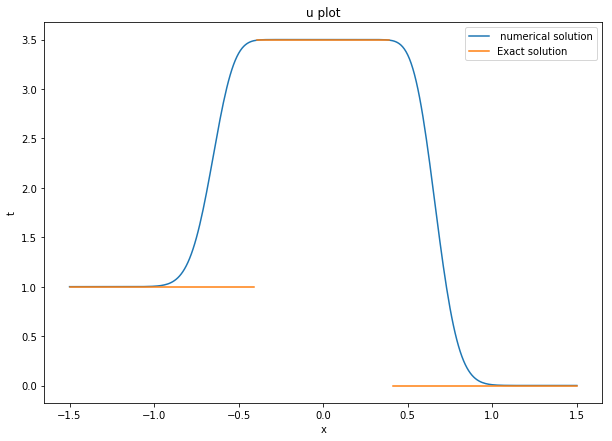

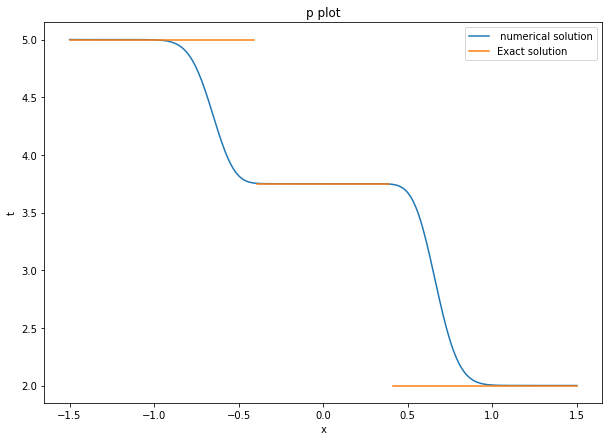

In [109]:
coef = [0.4, 0, 0.6, 0] 
plt_draw_u(coef)
plt_draw_p(coef)

## Наименее осциллирующая на разрывных решениях схема второго порядка аппроксимации

$u_m ^{n+1} = -\frac{33}{125} u_{m-1}^{n+1} + \frac{2261}{3125} u_{m-1}^{n} + \frac{1833}{3125} u_{m}^{n} -  \frac{144}{3125} u_{m+1}^{n} $

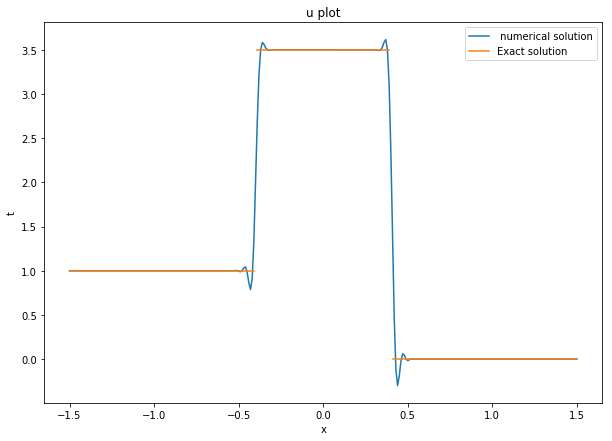

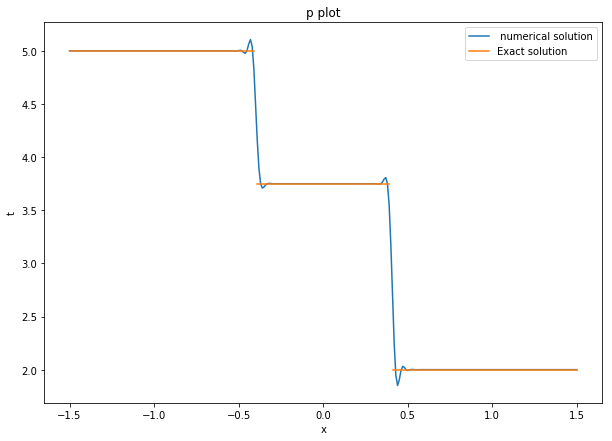

In [110]:
coef = [-33.0/125, 2261.0/3125, 1833.0/3125, -144.0/3125]
plt_draw_u(coef)
plt_draw_p(coef)

## Гибридная схема, показавшая себя наилучшим образом при выполнении Задания №1

Гибридная схема, полученная с одновременным использованием двух схем из пункта (3п), схемы из пункта (4п) и сеточно-характеристического критерия монотонности:

\begin{equation}
 \begin{cases}
   \alpha_{-1}^{1} = -{25\over7}\alpha_{1}^{0} - {3\over7}
   \\
   \alpha_{-1}^{0} = 6\alpha_{1}^{0}  + 1
   \\
   \alpha_{0}^{0} = -{24\over7}\alpha_{1}^{0} + {3\over7}
 \end{cases}
\end{equation}

В точках __ (3/7; 0), (27/35; -0.1) __ и

$$ u_m ^{n+1} = -{1\over 4}u_{m-1}^{n+1} + {7\over 10}u_{m-1}^{n} + {3\over 5}u_{0}^{0} -{1\over 20}u_{m+1}^{n} $$

Наклон характеристики $dx/dt= \lambda = c_0 = 2$.

Число Куранта: $ \sigma = {\lambda\tau\over h}= {2\tau\over h} = 0.4 $

${\tau\over h} = 0.2$

Шаблон:
![title](scheme_2.png)

На данном шаблоне это будет прямая с наклоном 5, поэтому при проэкции вдоль этой прямой на n-ый слой, точка __(m; n+1)__ будет между __(m; n)__ и __(m-1; n)__.

На обратном шаблоне это будет прямая с наклоном -5, так как $\sigma < 0$, поэтому при проэкции вдоль этой прямой на n-ый слой, точка __(m; n+1)__ будет между __(m; n)__ и __(m+1; n)__.

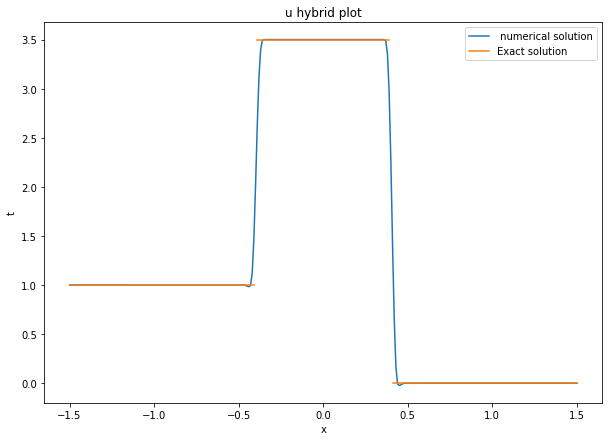

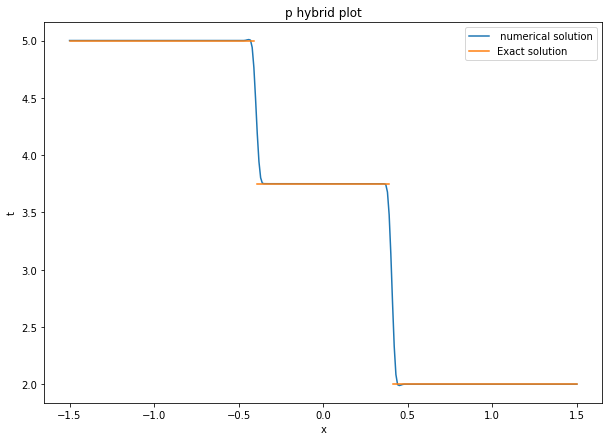

In [111]:
coef = [[-1.0/4, 0.7, 0.6, -1.0/20], [-3.0/7, 1.0, 3.0/7, 0], [-1.0/14, 2.0/5, 27.0/35, -0.1]]
plt_draw_u_hybrid3(coef)
plt_draw_p_hybrid3(coef)